In [1]:
import jax.numpy as np
import matplotlib.pyplot as plt

In [2]:
def lsp(A, phi, theta):
    return (
        A*np.exp(theta * np.tan(np.deg2rad(phi)))
        * np.stack((np.cos(theta), np.sin(theta)))
    ).T

In [3]:
_t = np.linspace(0, 2*np.pi, 200)

/Users/tlingard/anaconda3/lib/python3.6/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


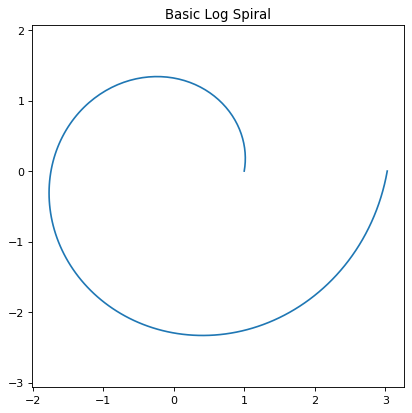

In [4]:
plt.figure(figsize=(6, 6), dpi=80)
plt.plot(*lsp(1, 10, _t).T)
plt.axis('equal')
plt.title('Basic Log Spiral');

In [5]:
def rotmx(a):
    return np.array(((np.cos(a), np.sin(a)), (-np.sin(a), np.cos(a))))

def inclined_lsp(A, phi, q, psi, theta):
    Q = np.array(((q, 0), (0, 1)))
    elliptcial = np.squeeze(np.dot(Q, np.expand_dims(lsp(A, phi, theta), -1))).T
    return np.squeeze(np.dot(rotmx(psi), np.expand_dims(elliptcial, -1))).T

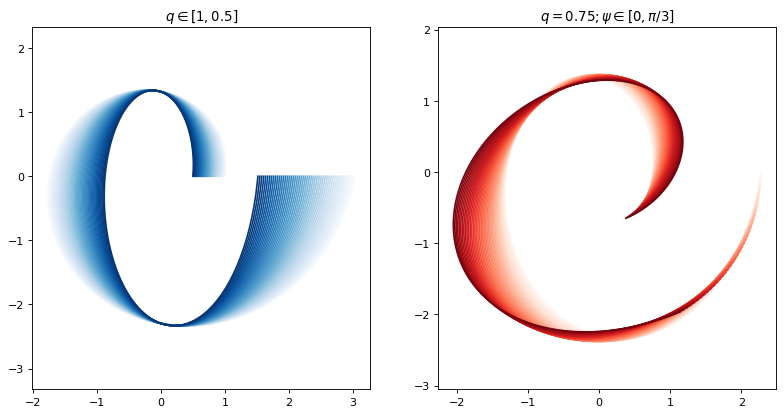

In [6]:
from matplotlib import cm
plt.figure(figsize=(12, 6), dpi=80)
plt.subplot(121)
c = cm.Blues
_q = (1 - np.linspace(0, 0.5, 50))
for i, q in enumerate(_q):
    plt.plot(*inclined_lsp(1, 10, q, 0, _t).T, c=c(i/len(_q)))
plt.axis('equal')
plt.title(r'$q \in [1, 0.5]$')
c = cm.Reds
plt.subplot(122)
_psi = np.linspace(0, np.pi/3, 40)
for i, psi in enumerate(_psi):
    plt.plot(*inclined_lsp(1, 10, 0.75, psi, _t).T, c=c(i/len(_psi)))
plt.title(r'$q = 0.75; \psi \in [0, \pi/3]$')
plt.axis('equal');

However, we do not want spiral position to be relative to disc rotation. How can we change our parameters to account for changes in disk rotation, so as to minimize the positional change of the spiral arm, while keeping a correct log spiral relative to the inclined rotated disk?

The answer is simply to update $\theta$... (hopefully?)

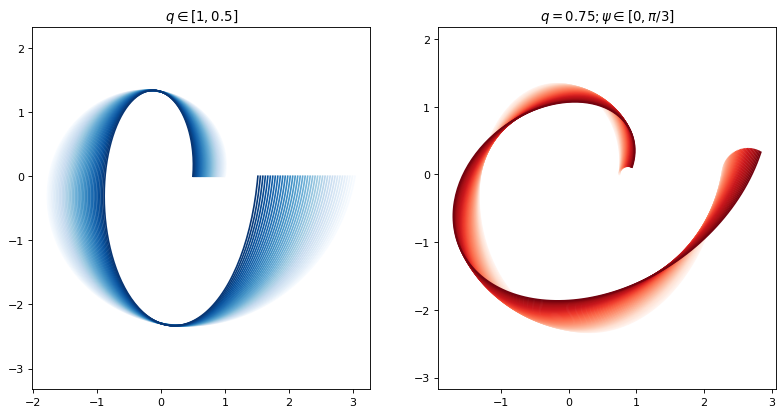

In [8]:
def correct_logsp_params(A, phi, q, psi, dpsi, theta):
    Ap = np.exp(-dpsi * np.tan(np.deg2rad(phi)))
    return A * Ap, phi, q, psi, theta + dpsi

def corrected_inclined_lsp(A, phi, q, psi, dpsi, theta):
    return inclined_lsp(
        *correct_logsp_params(A, phi, q, psi, dpsi, theta)
    )

plt.figure(figsize=(12, 6), dpi=80)
plt.subplot(121)
c = cm.Blues
_q = (1 - np.linspace(0, 0.5, 40))
for i, q in enumerate(_q):
    plt.plot(*corrected_inclined_lsp(1, 10, q, 0, 0, _t).T, c=c(i/len(_q)))
plt.axis('equal')
plt.title(r'$q \in [1, 0.5]$')
c = cm.Reds
plt.subplot(122)
_psi = np.linspace(0, np.pi/3, 40)
for i, psi in enumerate(_psi):
    dpsi = psi - _psi[0]
    plt.plot(*corrected_inclined_lsp(1, 10, 0.75, psi, dpsi, _t).T, c=c(i/len(_psi)))
plt.title(r'$q = 0.75; \psi \in [0, \pi/3]$')
plt.axis('equal');

In [9]:
from jax import jit

In [10]:
@jit
def __rotmx(a):
    return np.array(((np.cos(a), np.sin(a)), (-np.sin(a), np.cos(a))))


@jit
def __lsp(A, phi, theta):
    return (
        A*np.exp(theta * np.tan(np.deg2rad(phi)))
        * np.stack((np.cos(theta), np.sin(theta)))
    ).T


@jit
def inclined_lsp(A, phi, q, psi, theta):
    Q = np.array(((q, 0), (0, 1)))
    elliptcial = np.squeeze(
        np.dot(Q, np.expand_dims(__lsp(A, phi, theta), -1))
    ).T
    return np.squeeze(np.dot(__rotmx(psi), np.expand_dims(elliptcial, -1))).T


def correct_logsp_params(A, phi, q, psi, dpsi, theta):
    Ap = np.exp(-dpsi * np.tan(np.deg2rad(phi)))
    return A * Ap, phi, q, psi, theta + dpsi


@jit
def corrected_inclined_lsp(A, phi, q, psi, dpsi, theta):
    return inclined_lsp(
        *correct_logsp_params(A, phi, q, psi, dpsi, theta)
    )

@jit
def translate_spiral(lsp, mux, muy):
    return lsp + np.array((mux, muy))

In [20]:
%timeit translate_spiral(corrected_inclined_lsp(1, 10, 1, 0, 0, _t), 10, 10)

691 µs ± 77.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
